### Paso 1. Abrir el archivo de datos y leer la información general

In [103]:
import pandas as pd
from matplotlib import pyplot as plt  
from statsmodels.stats.proportion import proportions_ztest
import plotly.express as px
from plotly import graph_objects as go
import numpy as np 
import seaborn as sns
import datetime as dt  

In [104]:
# Importando archivos 
df_logs = pd.read_csv('/datasets/logs_exp_us.csv', sep="\t")
## las columnas estan separadas por secuencias de escape de tabulaciones

In [105]:
print (df_logs)
print(df_logs.columns)

                      EventName         DeviceIDHash  EventTimestamp  ExpId
0              MainScreenAppear  4575588528974610257      1564029816    246
1              MainScreenAppear  7416695313311560658      1564053102    246
2       PaymentScreenSuccessful  3518123091307005509      1564054127    248
3              CartScreenAppear  3518123091307005509      1564054127    248
4       PaymentScreenSuccessful  6217807653094995999      1564055322    248
...                         ...                  ...             ...    ...
244121         MainScreenAppear  4599628364049201812      1565212345    247
244122         MainScreenAppear  5849806612437486590      1565212439    246
244123         MainScreenAppear  5746969938801999050      1565212483    246
244124         MainScreenAppear  5746969938801999050      1565212498    246
244125       OffersScreenAppear  5746969938801999050      1565212517    246

[244126 rows x 4 columns]
Index(['EventName', 'DeviceIDHash', 'EventTimestamp', 'ExpId'

### Paso 2. Preparar los datos para el análisis

#### a. Cambiar el nombre de las columnas 

In [106]:
df_logs.columns = ['event', 'userId', 'eventTimestamp', 'group']
print(df_logs.columns)

Index(['event', 'userId', 'eventTimestamp', 'group'], dtype='object')


#### b. Comprueba los tipos de datos y valores ausentes. Corrige los datos si es necesario.

In [107]:
df_logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event           244126 non-null  object
 1   userId          244126 non-null  int64 
 2   eventTimestamp  244126 non-null  int64 
 3   group           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [108]:
# Convertir a datetime
df_logs["eventDatetime"] = pd.to_datetime(df_logs["eventTimestamp"], unit="s")

#### c. Agrega una columna de fecha y hora y una columna separada para las fechas.

In [109]:
# Crear columna solo con la fecha
df_logs["eventDate"] = df_logs["eventDatetime"].dt.date

# Crear columna solo con la hora
df_logs["eventTime"] = df_logs["eventDatetime"].dt.time

In [110]:
print(df_logs)

                          event               userId  eventTimestamp  group  \
0              MainScreenAppear  4575588528974610257      1564029816    246   
1              MainScreenAppear  7416695313311560658      1564053102    246   
2       PaymentScreenSuccessful  3518123091307005509      1564054127    248   
3              CartScreenAppear  3518123091307005509      1564054127    248   
4       PaymentScreenSuccessful  6217807653094995999      1564055322    248   
...                         ...                  ...             ...    ...   
244121         MainScreenAppear  4599628364049201812      1565212345    247   
244122         MainScreenAppear  5849806612437486590      1565212439    246   
244123         MainScreenAppear  5746969938801999050      1565212483    246   
244124         MainScreenAppear  5746969938801999050      1565212498    246   
244125       OffersScreenAppear  5746969938801999050      1565212517    246   

             eventDatetime   eventDate eventTime  


### Paso 3. Estudiar y comprobar los datos

#### a. ¿Cuántos eventos hay en los registros?

In [111]:
## Probando dos metodos
total_events = len(df_logs)                   ##funcion len
total_events2 = df_logs['event'].count()  ##usando count en una col
print(total_events, total_events2)
print ('Número total de eventos:', total_events)

df_logs['event'].unique()   ## posibles eventos

244126 244126
Número total de eventos: 244126


array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

#### b. ¿Cuántos usuarios hay en los registros?

In [112]:
unique_users = df_logs["userId"].nunique()
print ('Número de usuarios únicos:', unique_users)

Número de usuarios únicos: 7551


#### c. ¿Cuál es el promedio de eventos por usuario?

In [113]:
mean_events_per_user = total_events/unique_users
round(mean_events_per_user, 4)

32.3303

#### d. ¿Qué periodo de tiempo cubren los datos? 

In [114]:
min_date = df_logs["eventDate"].min()
max_date = df_logs["eventDate"].max()

print("Fecha mínima:", min_date)
print("Fecha máxima:", max_date)

Fecha mínima: 2019-07-25
Fecha máxima: 2019-08-07


Cubren desde finales de julio de 2019 hasta la primera semana de agosto.

##### ¿Puedes tener seguridad de que tienes datos igualmente completos para todo el periodo?
Si, se puede verificar la distribucion con ayuda de los graficos

<AxesSubplot:xlabel='eventDate'>

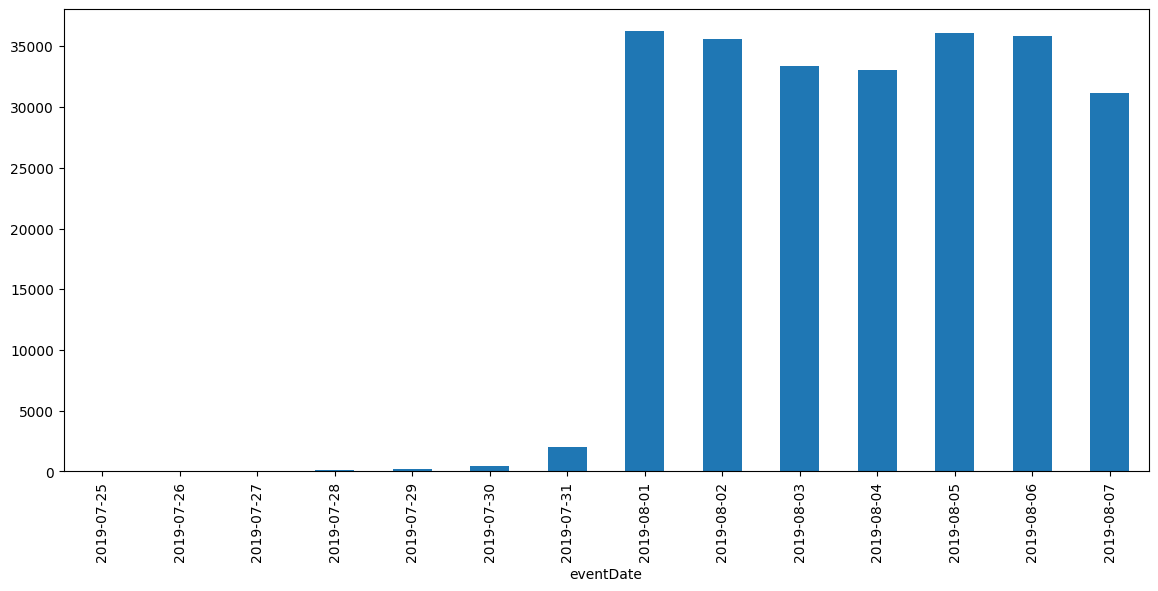

In [115]:
df_logs.groupby('eventDate')['userId'].count().plot(kind= 'bar', figsize=(14,6))

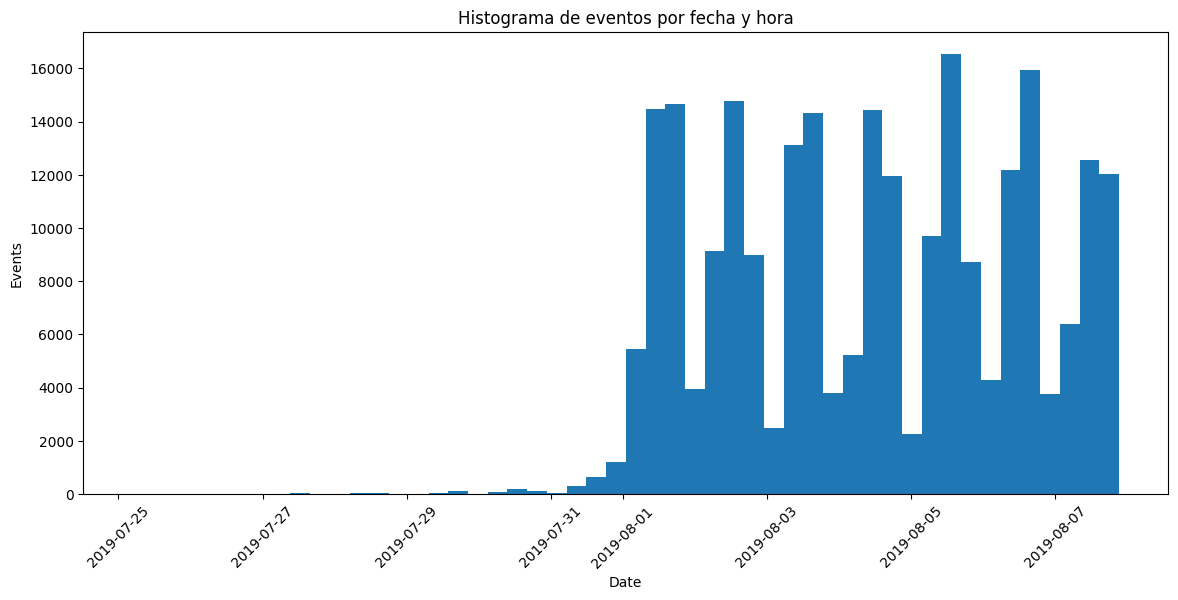

In [116]:
plt.figure(figsize=(14,6))
plt.hist(df_logs['eventDatetime'], bins=50)
plt.title("Histograma de eventos por fecha y hora")
plt.xlabel("Date")
plt.ylabel("Events")
plt.xticks(rotation=45)
plt.show()

De acuerdo a los graficos, los datos parecen estar completos desde el 1ero de agosto, por lo tanto, podemos considerar filtrar los datos a partir de esta fecha.

In [117]:
##  Encuentra el momento en el que los datos comienzan a estar completos e ignora la sección anterior.

df_logs_filtered = df_logs[df_logs['eventDate'] > pd.to_datetime('2019-07-31')]
df_logs_filtered.head()

,event,userId,eventTimestamp,group,eventDatetime,eventDate,eventTime
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01,00:07:28
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01,00:08:00
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01,00:08:55
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01,00:08:58
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01,00:08:59


In [118]:
# Verificando que la fecha minima del df filtrado sea el 1ero de agosto
print(df_logs_filtered['eventDate'].min())
print(df_logs_filtered['eventDate'].max())

2019-08-01
2019-08-07


##### ¿Qué periodo representan realmente los datos?

Desde el 1ero hasta el 7 de agosto. Es decir conservamos la misma fecha maxima, pero ignoramos la seccion antes del 1ero de agosto.

#### e. ¿Perdiste muchos eventos y usuarios al excluir los datos más antiguos?

In [119]:
# Para calcular el % de eventos perdidos
round (100*(1-((len(df_logs_filtered))/(len(df_logs)))), 4)

1.1584

In [120]:
# Para calcular el % de usuarios perdidos
round (100*(1-((df_logs_filtered['userId'].nunique())/(df_logs['userId'].nunique()))), 4)

0.2251

De acuerdo a los porcentajes calculados, excluir los datos más antiguos no causó una pérdida significativa ni de eventos ni de usuarios. La mayoría de la información se mantiene.

#### f. Asegúrate de tener usuarios de los tres grupos experimentales.

In [121]:
### contando los usuarios unicos por grupo en el df filtrado
df_logs_filtered.groupby('group')['userId'].nunique()

group
246    2484
247    2513
248    2537
Name: userId, dtype: int64

In [122]:
### otra forma es contando los registros por grupo
print(df_logs_filtered['group'].value_counts())

248    84726
246    79425
247    77147
Name: group, dtype: int64


### Paso 4. Estudiar el embudo de eventos

#### a. Observa qué eventos hay en los registros y su frecuencia de suceso. Ordénalos por frecuencia.

In [123]:
df_logs_filtered.groupby('event')['userId'].count().sort_values(ascending = False)

event
MainScreenAppear           117431
OffersScreenAppear          46350
CartScreenAppear            42365
PaymentScreenSuccessful     34113
Tutorial                     1039
Name: userId, dtype: int64

De acuerdo a la frecuencia de los eventos ocurridos, el evento mas frecuente fue MainScreenAppear, correspondiente a la navegación en la página principal. Otras actividades como OffersScreenAppear, CartScreenAppear y PaymentScreenSuccessful, que representan la exploración de ofertas, el uso del carrito y la finalización de pagos, también son bastante frecuentes. Sin embargo, la finalización de tutoriales es poco común, lo que sugiere que podrían implementarse mejoras que promuevan la participación en este evento. 

#### b. Encuentra la cantidad de usuarios que realizaron cada una de estas acciones

In [124]:
users_per_event = df_logs_filtered.groupby('event')['userId'].nunique().sort_values(ascending = False)
print(users_per_event)

event
MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Tutorial                    840
Name: userId, dtype: int64


In [125]:
n_users = df_logs_filtered["userId"].nunique()

In [126]:
prop_users_per_event = users_per_event / n_users
round(prop_users_per_event,4)

event
MainScreenAppear           0.9847
OffersScreenAppear         0.6096
CartScreenAppear           0.4956
PaymentScreenSuccessful    0.4697
Tutorial                   0.1115
Name: userId, dtype: float64

El 98.47 % de los usuarios pasó por el evento MainScreenAppear, mostrando que casi todos interactúan con la pantalla principal. Más de la mitad de los usuarios (60.96 %) accedió al evento OffersScreenAppear, mientras que los eventos CartScreenAppear (49.56 %) y PaymentScreenSuccessful (46.97 %) alcanzaron cerca del 50 % de participación de los usuarios. El evento con menor participación fue Tutorial, con solo un 11.15 % de los usuarios.

#### c. ¿En qué orden crees que ocurrieron las acciones? ¿Todas son parte de una sola secuencia?

La secuencia u orden en que ocurrieron las acciones, podría ser:
1. MainScreenAppear
2. OffersScreenAppear 
3. CartScreenAppear
4. PaymentScreenSuccessful

Mientras que el evento Tutorial ocurre de forma separada. Otra observacion importante es que los usuarios podrían pasar directamente al carrito sin explorar ofertas.

#### d. Utiliza el embudo de eventos para encontrar la proporción de usuarios que pasan de una etapa a la siguiente. 

In [127]:
funnel = df_logs_filtered.groupby('event')['userId'].nunique().reset_index()

In [128]:
funnel = funnel.sort_values(by = 'userId' , ascending = False)

In [129]:
# Usuarios en la etapa previa
funnel['users_prev_step'] = funnel['userId'].shift()
funnel['users_prev_step'] = funnel['users_prev_step'].fillna(7419)

In [130]:
# Proporción de usuarios que pasan de una etapa a la siguiente
funnel['prop_prev_step'] = funnel['userId'] / funnel['users_prev_step']

In [131]:
funnel = funnel.rename(columns={'userId':'users'})

In [132]:
# Para calcular el porcentaje de usuarios que se pierden
funnel['drop-off'] = 1 - funnel['prop_prev_step']

In [133]:
print(funnel)

                     event  users  users_prev_step  prop_prev_step  drop-off
1         MainScreenAppear   7419           7419.0        1.000000  0.000000
2       OffersScreenAppear   4593           7419.0        0.619086  0.380914
0         CartScreenAppear   3734           4593.0        0.812976  0.187024
3  PaymentScreenSuccessful   3539           3734.0        0.947777  0.052223
4                 Tutorial    840           3539.0        0.237355  0.762645


En proporción a los usuarios que llegaron a la pantalla principal (MainScreenAppear), aproximadamente el `61.9%` avanzó a ofertas.
De esos, un `81.3%` continuó hacia carrito.
Finalmente, el `94.8%` de quienes llegaron al carrito completaron el evento PaymentScreenSuccessful.
En contraste, aunque no forma parte del embudo, solo un `23.7%` de los usuarios realizó el Tutorial, lo que indica una participación baja en esta etapa.

#### e. ¿En qué etapa pierdes más usuarios?

Además del Tutorial, la etapa donde más usuarios se pierden es entre MainScreenAppear y OffersScreenAppear, donde se queda casi el 38 % de los usuarios.

#### f. ¿Qué porcentaje de usuarios hace todo el viaje desde su primer evento hasta el pago? 

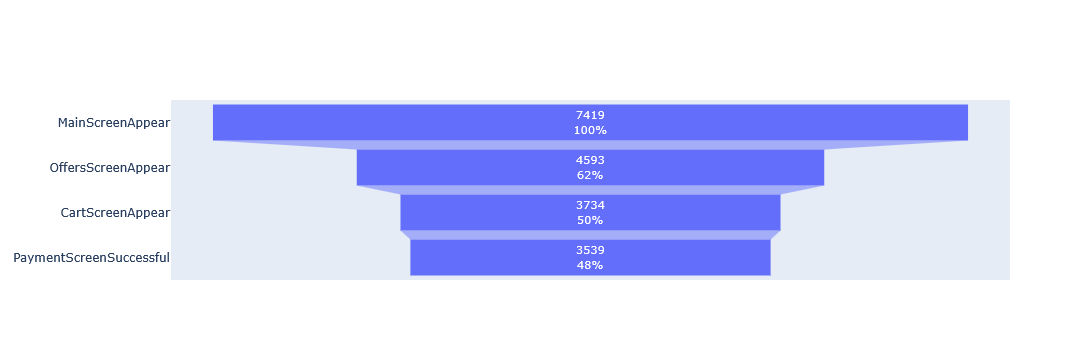

In [134]:
fig = go.Figure (go.Funnel(
    y = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful'],
    x = [7419, 4593, 3734, 3539],
    textinfo = 'value+percent initial'
))

fig.show()


Tal como muestra el embudo, la mayor perdida de usuarios ocurre en la transición inicial hacia la pantalla de ofertas. Mejorar aspectos como la visibilidad o el atractivo de esta sección podría aumentar significativamente la cantidad de usuarios que interactuan.
El resto del embudo funciona relativamente bien, por lo tanto, si se emplean esfuerzos para la optimización, deberían centrarse en los primeros pasos.


### Paso 5. Estudiar los resultados del experimento

#### a. ¿Cuántos usuarios hay en cada grupo?

In [135]:
## tal como en el punto f del paso 3:
df_logs_filtered.groupby(['group'])['userId'].nunique()

group
246    2484
247    2513
248    2537
Name: userId, dtype: int64

#### b. Observa si hay una diferencia estadísticamente significativa entre las muestras 246 y 247.

In [136]:
base = df_logs_filtered[['userId', 'group']].drop_duplicates()

In [137]:
unique_users = df_logs_filtered [df_logs_filtered['event'] == 'PaymentScreenSuccessful']['userId'].unique()

In [138]:
# Usuarios que si compraron
converted_users = pd.DataFrame({
    'userId': unique_users,
    'converted': 1
})

In [139]:
converted_users.sample(5)

,userId,converted
3005,6377824737203294106,1
1103,4639223369107552273,1
3177,8455446443714796356,1
3351,3202533323330399970,1
3077,3300673869838178431,1


In [140]:
df_payment = base.merge(converted_users, on='userId', how='left')
df_payment['converted'] = df_payment['converted'].fillna(0).astype(int)

In [141]:
df_payment.sample(5)

,userId,group,converted
2814,617306855803490709,247,0
4600,387505098052759672,246,1
7037,3699082799308019120,248,0
6824,837542968599109939,247,0
3886,2863001408302662673,246,1


In [142]:
## Separando en grupos
pay_group_246 = df_payment [df_payment['group'] == 246]['converted']
pay_group_247 = df_payment [df_payment['group'] == 247]['converted']

In [143]:
print(pay_group_246)

0       1
3       0
5       1
10      1
19      1
       ..
7510    0
7513    0
7519    1
7531    0
7532    1
Name: converted, Length: 2484, dtype: int64


In [144]:
print(pay_group_247)

1       0
2       1
8       1
9       1
15      0
       ..
7524    0
7526    0
7527    0
7528    0
7533    0
Name: converted, Length: 2513, dtype: int64


In [145]:
## Calculando tasas de conversion
conv_rate_246 = pay_group_246.mean()
conv_rate_247 = pay_group_247.mean()

In [146]:
print("Tasa de conversión grupo 246:", conv_rate_246)
print("Tasa de conversión grupo 247:", conv_rate_247)

Tasa de conversión grupo 246: 0.4830917874396135
Tasa de conversión grupo 247: 0.46080382013529647


In [147]:
# Número de conversiones en cada grupo
conversions = [pay_group_246.sum(), pay_group_247.sum()]
# Tamaño de cada grupo
n_observations = [len(pay_group_246), len(pay_group_247)]

# Ejecutar la prueba
z_stat, p_value = proportions_ztest(conversions, n_observations)
print(f"Z-statistic: {z_stat}")
print(f"P-value: {p_value}")

Z-statistic: 1.5779948491596598
P-value: 0.11456679313141847


In [148]:
alpha= 0.05
if p_value < alpha:
    mejor_grupo = '246' if conv_rate_246 > conv_rate_247 else '247'
    print('La diferencia es estadísticamente significativa.')
    print(f'El grupo {mejor_grupo} tiene la mayor tasa de conversión.')
else:
    print('No se encontró diferencia estadísticamente significativa.')

No se encontró diferencia estadísticamente significativa.


La tasa de conversión del grupo 246 fue de 48.31%, mientras que la del grupo 247 fue de 46.08%. Al realizar la prueba de proporciones, se obtuvo un p-value de 0.1146, mayor que el nivel de significancia (α = 0.05). Por lo tanto, no se encuentra evidencia estadísticamente significativa de que exista una diferencia real entre los grupos. Es decir, que la variación observada de 2.23 puntos porcentuales puede deberse por el azar.

#### c. Selecciona el evento más popular.
MainScreenAppear

##### En cada uno de los grupos de control, encuentra la cantidad de usuarios que realizaron esta acción.

In [149]:
##  función especial para los grupos por evento

def build_group(df, group_id, event_name):
    # Filtrar por grupo
    group_df = df[df['group'] == group_id]
    
    # Obtener usuarios únicos que realizaron el evento
    users_with_event = group_df[group_df['event'] == event_name]['userId'].nunique()
    
    # Total de usuarios únicos en el grupo
    total_users = group_df['userId'].nunique()
    
    # Calcular tasa de conversión
    rate = users_with_event / total_users if total_users > 0 else 0
    
    return {
        'group_id': group_id,
        'conversions': users_with_event,  # Usuarios únicos que hicieron el evento
        'group_size': total_users,        # Total usuarios únicos en el grupo
        'rate': rate

    }

In [150]:
##  función especial para la prueba





def compare_groups(group1, group2, alpha=0.05):
    # Paso 1: Conversiones
    conversions = [group1['conversions'], group2['conversions']]
    
    # Paso 2: Observaciones
    n_obs = [group1['group_size'], group2['group_size']]
    
    # Paso 3: Prueba estadística
    z_stat, p_value = proportions_ztest(conversions, n_obs)
    
    # Paso 4: Interpretar resultados 

    conclusion = 'No hay diferencia estadísticamente significativa.'
    
    if p_value < alpha:
         conclusion = 'Diferencia estadísticamente significativa.'
    
    print (f'p = {p_value:.4f} → {conclusion}')







In [151]:
## Construyendo los grupos para la pagina principal
main_group_246 = build_group(df_logs_filtered, 246, 'MainScreenAppear')
main_group_247 = build_group(df_logs_filtered, 247, 'MainScreenAppear')

In [152]:
print(main_group_246)

{'group_id': 246, 'conversions': 2450, 'group_size': 2484, 'rate': 0.9863123993558777}


In [153]:
print(main_group_247)

{'group_id': 247, 'conversions': 2476, 'group_size': 2513, 'rate': 0.9852765618782332}


In [154]:
compare_groups(main_group_246, main_group_247)

p = 0.7571 → No hay diferencia estadísticamente significativa.


Como el p-value es alto, no hay evidencia estadística de que los grupos sean distintos en la métrica analizada.

##### Repite el procedimiento para todos los demás eventos

###### Comparacion para  'OffersScreenAppear'

In [155]:
## Construyendo los grupos para Ofertas
offers_group_246 = build_group(df_logs_filtered, 246, 'OffersScreenAppear')
offers_group_247 = build_group(df_logs_filtered, 247, 'OffersScreenAppear')

In [156]:
print(offers_group_246)

{'group_id': 246, 'conversions': 1542, 'group_size': 2484, 'rate': 0.6207729468599034}


In [157]:
print(offers_group_247)

{'group_id': 247, 'conversions': 1520, 'group_size': 2513, 'rate': 0.6048547552725826}


In [158]:
compare_groups(offers_group_246, offers_group_247)

p = 0.2481 → No hay diferencia estadísticamente significativa.


###### Comparacion para  'CartScreenAppear'

In [159]:
## Construyendo los grupos para el Carro
cart_group_246 = build_group(df_logs_filtered, 246, 'CartScreenAppear')
cart_group_247 = build_group(df_logs_filtered, 247, 'CartScreenAppear')

In [160]:
print(cart_group_246)

{'group_id': 246, 'conversions': 1266, 'group_size': 2484, 'rate': 0.5096618357487923}


In [161]:
print(cart_group_247)

{'group_id': 247, 'conversions': 1238, 'group_size': 2513, 'rate': 0.4926382809391166}


In [162]:
compare_groups(cart_group_246, cart_group_247)

p = 0.2288 → No hay diferencia estadísticamente significativa.


###### Comparacion para 'PaymentScreenSuccessful'

In [163]:
## Construyendo los grupos para el evento de pago

payment_group_246 = build_group(df_logs_filtered, 246, 'PaymentScreenSuccessful')

payment_group_247 = build_group(df_logs_filtered, 247, 'PaymentScreenSuccessful')

In [164]:
print(payment_group_246)

{'group_id': 246, 'conversions': 1200, 'group_size': 2484, 'rate': 0.4830917874396135}


In [165]:
print(payment_group_247)

{'group_id': 247, 'conversions': 1158, 'group_size': 2513, 'rate': 0.46080382013529647}


In [166]:
compare_groups(payment_group_246, payment_group_247)

p = 0.1146 → No hay diferencia estadísticamente significativa.


#### d. Haz lo mismo para el grupo con fuentes alteradas. Compara los resultados con los de cada uno de los grupos de control para cada evento de forma aislada. 

###### Comparacion para 'MainScreenAppear'

In [167]:
main_group_248 = build_group(df_logs_filtered, 248, 'MainScreenAppear')

In [168]:
print(main_group_248)

{'group_id': 248, 'conversions': 2493, 'group_size': 2537, 'rate': 0.9826566811194324}


In [169]:
compare_groups(main_group_247, main_group_248)

p = 0.4587 → No hay diferencia estadísticamente significativa.


In [170]:
compare_groups(main_group_246, main_group_248)

p = 0.2950 → No hay diferencia estadísticamente significativa.


###### Comparacion para  'OffersScreenAppear'

In [171]:
offers_group_248 = build_group(df_logs_filtered, 248, 'OffersScreenAppear')

In [172]:
print(offers_group_248)

{'group_id': 248, 'conversions': 1531, 'group_size': 2537, 'rate': 0.6034686637761135}


In [173]:
compare_groups(offers_group_247, offers_group_248)

p = 0.9198 → No hay diferencia estadísticamente significativa.


In [174]:
compare_groups(offers_group_246, offers_group_248)

p = 0.2084 → No hay diferencia estadísticamente significativa.


###### Comparacion para 'CartScreenAppear'

In [175]:
cart_group_248 = build_group(df_logs_filtered, 248, 'CartScreenAppear')

In [176]:
print(cart_group_248)

{'group_id': 248, 'conversions': 1230, 'group_size': 2537, 'rate': 0.48482459597950334}


In [177]:
compare_groups(cart_group_247, cart_group_248)

p = 0.5786 → No hay diferencia estadísticamente significativa.


In [178]:
compare_groups(cart_group_246, cart_group_248)

p = 0.0784 → No hay diferencia estadísticamente significativa.


###### Comparacion para 'PaymentScreenSuccessful'

In [179]:
payment_group_248 = build_group(df_logs_filtered, 248, 'PaymentScreenSuccessful')

In [180]:
print(payment_group_248)

{'group_id': 248, 'conversions': 1181, 'group_size': 2537, 'rate': 0.46551044540796216}


In [181]:
compare_groups(payment_group_247, payment_group_248)

p = 0.7373 → No hay diferencia estadísticamente significativa.


In [182]:
compare_groups(payment_group_246, payment_group_248)

p = 0.2123 → No hay diferencia estadísticamente significativa.


Al comparar grupos con fuentes alteradas (248) contra los controles, no hay evidencia estadísticamente significativa de cambios en el comportamiento de los usuarios en ninguno de los eventos.

No obstante, en la comparación 246 vs 248, p ≈ 0.0784, se acerca al umbral de significancia, lo que podría sugerir una posible tendencia. Sin embargo, esta diferencia no es suficiente para concluir la existencia de un efecto real.

#### e. ¿Qué nivel de significancia has establecido para probar las hipótesis estadísticas mencionadas anteriormente?
alpha = 0.05

##### Calcula cuántas pruebas de hipótesis estadísticas has realizado. 
3 pruebas (246 vs 247, 247 vs 248 y 246 vs 248) por cada evento (main, offers, cart, payment)

Total de pruebas:      3 × 4 = 12 pruebas

##### ¿Cuál debería ser el nivel de significancia? 

Para minimizar el FWER (Tasa de Error por Familias), los metodos de corrección se aplican a nivel de significacion. La corrección más común y más aproximada del nivel de significacion requerido es la corrección de Bonferroni. En esta el nivel de significación se divide entre el numero de pruebas:

`α_corr = α / número de pruebas = 0.05 / 12 ≈ 0.0042`

###### Comparación entre grupos de control

In [189]:
compare_groups(main_group_246, main_group_247, alpha=0.0042)

p = 0.7571 → No hay diferencia estadísticamente significativa.


In [190]:
compare_groups(offers_group_246, offers_group_247, alpha=0.0042)

p = 0.2481 → No hay diferencia estadísticamente significativa.


In [191]:
compare_groups(cart_group_246, cart_group_247, alpha=0.0042)

p = 0.2288 → No hay diferencia estadísticamente significativa.


In [192]:
compare_groups(payment_group_246, payment_group_247, alpha=0.0042)

p = 0.1146 → No hay diferencia estadísticamente significativa.


###### Comparación con el grupo con fuentes alteradas

In [193]:
compare_groups(main_group_247, main_group_248, alpha=0.0042)

p = 0.4587 → No hay diferencia estadísticamente significativa.


In [99]:
compare_groups(main_group_246, main_group_248, alpha=0.0042)

p = 0.2950 → No hay diferencia estadísticamente significativa.


In [194]:
compare_groups(offers_group_247, offers_group_248, alpha=0.0042)

p = 0.9198 → No hay diferencia estadísticamente significativa.


In [195]:
compare_groups(offers_group_246, offers_group_248, alpha=0.0042)

p = 0.2084 → No hay diferencia estadísticamente significativa.


In [196]:
compare_groups(cart_group_247, cart_group_248, alpha=0.0042)

p = 0.5786 → No hay diferencia estadísticamente significativa.


In [197]:
compare_groups(cart_group_246, cart_group_248, alpha=0.0042)

p = 0.0784 → No hay diferencia estadísticamente significativa.


In [198]:
compare_groups(payment_group_247, payment_group_248, alpha=0.0042)

p = 0.7373 → No hay diferencia estadísticamente significativa.


In [199]:
compare_groups(payment_group_246, payment_group_248, alpha=0.0042)

p = 0.2123 → No hay diferencia estadísticamente significativa.


Ninguno de los valores p obtenidos en las comparaciones es menor que el umbral ajustado. Incluso considerando la posible tendencia observada en el evento cart (p ≈ 0.0784), no se encuentra evidencia estadísticamente significativa de que las fuentes alteradas (grupo 248) generen cambios en el comportamiento de los usuarios.

Por ende, tras aplicar el procedimiento de Bonferroni, ninguna de las diferencias entre grupos resulta estadísticamente significativa.